# Forecasting Methodology

## **Methodology:**  
Exogenous Time Series Forecasting with ARIMA and SARIMAX.  
This approach involves leveraging historical data to predict the future behavior of a target variable while incorporating exogenous features to improve model accuracy.

---

## **Data Division**
- **Split the Dataset:**
    - Divide the dataset into training and testing sets based on a `train_size` parameter.
    - Ensure the test set is reserved for out-of-sample evaluation.

---

## **ARIMA Modeling**
1. **Automatic Order Selection:**
    - Use `auto_arima` to automatically determine the optimal `(p, d, q)` parameters for the ARIMA model.
    - Include exogenous variables for better modeling of the target variable.

2. **Model Training:**
    - Fit a SARIMAX (Seasonal ARIMA with Exogenous Variables) model to the training data using the selected parameters.
    - Incorporate relevant exogenous features identified during data preprocessing.

---

## **Predictions and Assessment**
1. **Generate Predictions:**
    - Predict values for the training and test datasets using the trained SARIMAX model.
    - Optionally, generate predictions for future time steps based on provided exogenous forecasts.

2. **Evaluate Performance:**
    - Compute key performance metrics:
        - **MSE** (Mean Squared Error)
        - **RMSE** (Root Mean Squared Error)
        - **MAE** (Mean Absolute Error)
        - **R²** (Coefficient of Determination)

---

## **Exogenous Variable Prediction**
1. **Optimal Lags Selection:**
    - Determine the most significant lag for each exogenous variable using `auto_arima` or correlation analysis.
    - Add these lagged variables as features to the dataset.

2. **Exogenous Forecasting:**
    - Train machine learning models or ARIMA models for predicting exogenous variables.
    - Use methods like GridSearchCV or auto_arima to select the best-performing model based on metrics like MSE.

3. **Future Exogenous Forecasts:**
    - Predict future values of the exogenous variables to serve as inputs for forecasting the target variable.

---

## **Future Forecast**
- Generate multi-step forecasts of the target variable by leveraging future predictions of exogenous features and extending the SARIMAX model.

---

## **Visualization**
- **Training and Testing Performance:**
    - Plot actual vs. predicted values for both training and test datasets.
    - Overlay predictions on the original time series to visualize the model’s accuracy.

- **Future Forecast:**
    - If applicable, visualize forecasts for the target variable over the desired time horizon using the predicted exogenous inputs.


# Importar bibliotecas necessárias

In [1]:
import os
import pandas as pd
from tsSarimax.models.predictor import ARIMAPredictor
from tsSarimax.utils.data_preprocessor import DataPreprocessor
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Carregar os dados

In [2]:
data_dir = '/home/hayda/Documentos/ssd/eTechShowCase/etssax/tsSarimax/datatsets'
data_file = os.path.join(data_dir, 'day.csv')
data = pd.read_csv(data_file)

# Pré-processamento dos dados

In [3]:
data['dteday'] = pd.to_datetime(data['dteday'])
# Extrair características de data
data['year'] = data['dteday'].dt.year
data['month'] = data['dteday'].dt.month
data['day'] = data['dteday'].dt.day
data['dayofweek'] = data['dteday'].dt.dayofweek
data.drop('dteday', axis=1, inplace=True)

preprocessor = DataPreprocessor(data, target_col='cnt')
data = preprocessor.preprocess(scale_numeric=True, drop_first=True)

# Selecionar colunas com base na correlação

In [4]:
threshold_min = 0.5
threshold_max = 0.9
target_col = 'cnt'  # Substitua pelo nome da variável alvo, se necessário

dummies_cols, _ = preprocessor.get_processed_columns()

data_for_correlation = data.drop(columns=dummies_cols)
correlation_matrix = data_for_correlation.corr()

selected_columns = correlation_matrix.index[
    (abs(correlation_matrix[target_col]) >= threshold_min) & (abs(correlation_matrix[target_col]) <= threshold_max)
].tolist()

if target_col not in selected_columns:
    selected_columns.append(target_col)

feature_cols = selected_columns + dummies_cols
feature_exog  = [col for col in selected_columns if col !=target_col] 

filtered_data = data[feature_cols]

feature_exog

['instant', 'yr', 'temp', 'atemp', 'casual', 'year']

# Separar os dados em treino e validação

In [5]:
total_observations = len(filtered_data)
validation_size = int(0.1 * total_observations)
validation_start_index = total_observations - validation_size

train_data = filtered_data.iloc[:validation_start_index]
validation_data = filtered_data.iloc[validation_start_index:]
validation_data = validation_data.reset_index(drop=True)
feature_exog_in_validation = [col for col in validation_data.columns if col in feature_exog] 
feature_exog_in_validation

['instant', 'yr', 'temp', 'atemp', 'casual', 'year']

# Usando a classe ARIMAPredictor
Inicializar a classe com os dados de treinamento

In [6]:
predictor = ARIMAPredictor(train_data, target_col)

# Executar previsões com SARIMAX

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9715.391, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9650.502, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9553.328, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9713.454, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9518.984, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9519.966, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9520.180, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9519.199, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9614.697, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9520.562, Time=0.07 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.573 seconds


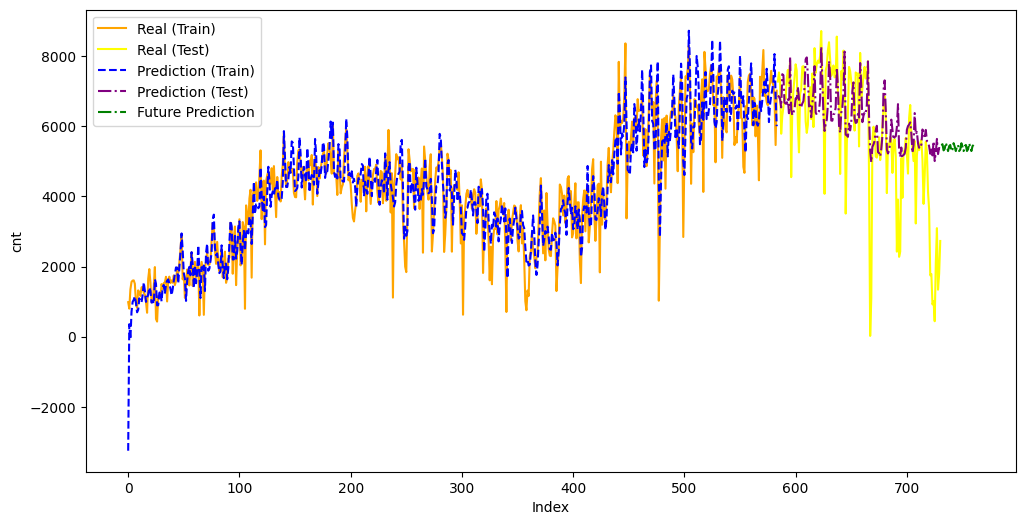

In [7]:
# Inicializar a instância com os dados
predictor = ARIMAPredictor(data, target_col=target_col)

# Treinar e obter o modelo ajustado com SARIMAX
train_preds, test_preds, future_preds, model_fit, train_metrics, test_metrics = predictor.train_and_predict_sarimax(
    feature_cols=feature_exog,
    seasonal=True,
    stepwise=True,
    forecast_horizon=30
)

# Exibir resultados

In [8]:
print("Train Metrics:")
print(f"  Mean Squared Error (MSE): {train_metrics[0]:.4f}")
print(f"  Root Mean Squared Error (RMSE): {train_metrics[1]:.4f}")
print(f"  Mean Absolute Error (MAE): {train_metrics[2]:.4f}")
print(f"  R-squared (R2): {train_metrics[3]:.4f}")
print(f"  Combined Score: {train_metrics[4]:.4f}")

print("Test Metrics:")
print(f"  Mean Squared Error (MSE): {test_metrics[0]:.4f}")
print(f"  Root Mean Squared Error (RMSE): {test_metrics[1]:.4f}")
print(f"  Mean Absolute Error (MAE): {test_metrics[2]:.4f}")
print(f"  R-squared (R2): {test_metrics[3]:.4f}")
print(f"  Combined Score: {test_metrics[4]:.4f}")

Train Metrics:
  Mean Squared Error (MSE): 509453.4739
  Root Mean Squared Error (RMSE): 713.7601
  Mean Absolute Error (MAE): 543.2720
  R-squared (R2): 0.8405
  Combined Score: 127677.6664
Test Metrics:
  Mean Squared Error (MSE): 2292536.7381
  Root Mean Squared Error (RMSE): 1514.1125
  Mean Absolute Error (MAE): 1083.6907
  R-squared (R2): 0.3476
  Combined Score: 573783.7984


# Previsões futuras

In [9]:
print(f"Future Predictions: {future_preds}")

Future Predictions: 584    5460.705612
585    5487.780572
586    5312.071315
587    5355.373693
588    5528.729245
589    5421.097537
590    5291.328320
591    5431.408392
592    5465.202623
593    5289.840230
594    5339.564849
595    5518.430624
596    5416.505947
597    5292.167857
598    5433.111006
599    5466.081236
600    5292.078115
601    5341.079772
602    5515.999029
603    5413.523238
604    5292.242748
605    5433.902370
606    5466.524173
607    5294.228748
608    5342.687162
609    5513.793991
610    5410.799860
611    5292.444389
612    5434.632161
613    5466.786283
Name: predicted_mean, dtype: float64


# Previsões no conjunto de validação

# Análise dos resíduos


Análise de Resíduos no Conjunto de Validação:


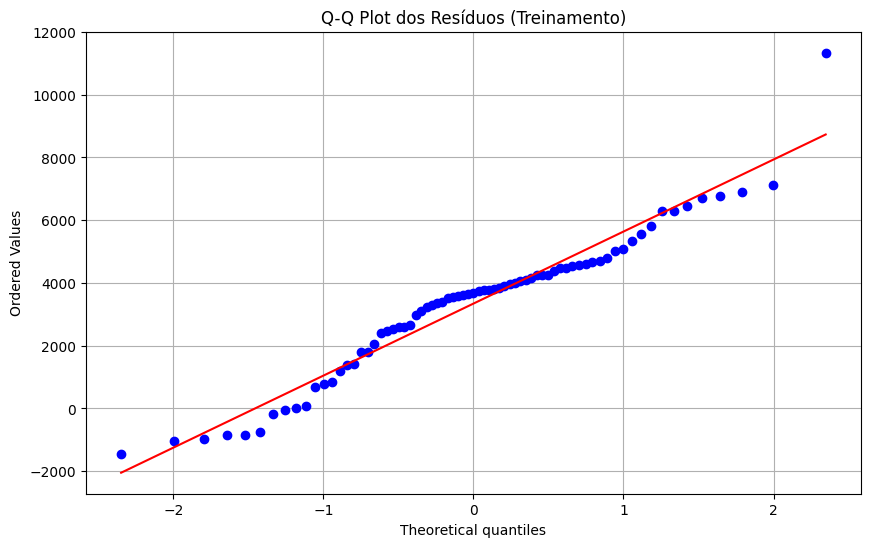

Resultados dos testes estatísticos (Treinamento):
- Breusch-Pagan: estatística=44.6242, p-valor=0.0000
- White: estatística=55.4199, p-valor=0.0000
- Durbin-Watson: estatística=0.1398, p-valor=N/A
- ADF: estatística=-4.1996, p-valor=0.0007
- Ljung-Box: estatística=N/A, p-valor=N/A

Conclusões:
- Os resíduos são estacionários, indicando que o modelo captura bem a dinâmica dos dados.
- Há evidências de autocorrelação nos resíduos, indicando perda de informações no modelo.
- Há evidências de heterocedasticidade, indicando variância não constante.
- A estatística Durbin-Watson indica evidências de autocorrelação.


In [10]:
# Análise de resíduos no conjunto de validação
print("\nAnálise de Resíduos no Conjunto de Validação:")
predictor.analyze_residuals(model_fit=model_fit, dataset=validation_data, X=validation_data[feature_exog_in_validation], dataset_label="Treinamento")
